<a href="https://colab.research.google.com/github/Thebtiboutheina/Flight-Price-Prediction/blob/main/data_preprocessing%2Bmodeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q kaggle

In [8]:
# Import necessary libraries
import os

# Create a kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the kaggle.json file into the newly created kaggle directory
!mv kaggle.json /root/.kaggle/kaggle.json

# Change the permissions of the file
!chmod 600 /root/.kaggle/kaggle.json


In [9]:
!kaggle datasets download -d shubhambathwal/flight-price-prediction

 96% 4.00M/4.16M [00:00<00:00, 6.12MB/s]
100% 4.16M/4.16M [00:00<00:00, 4.59MB/s]


In [10]:
!unzip flight-price-prediction.zip


Archive:  flight-price-prediction.zip
  inflating: Clean_Dataset.csv       
  inflating: business.csv            
  inflating: economy.csv             


# Imports

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing

# load dataset

In [12]:
#load the dataset
data = pd.read_csv('Clean_Dataset.csv', usecols=lambda col: col!='Unnamed: 0')
data

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


# Pre-processing

## **Missing values**

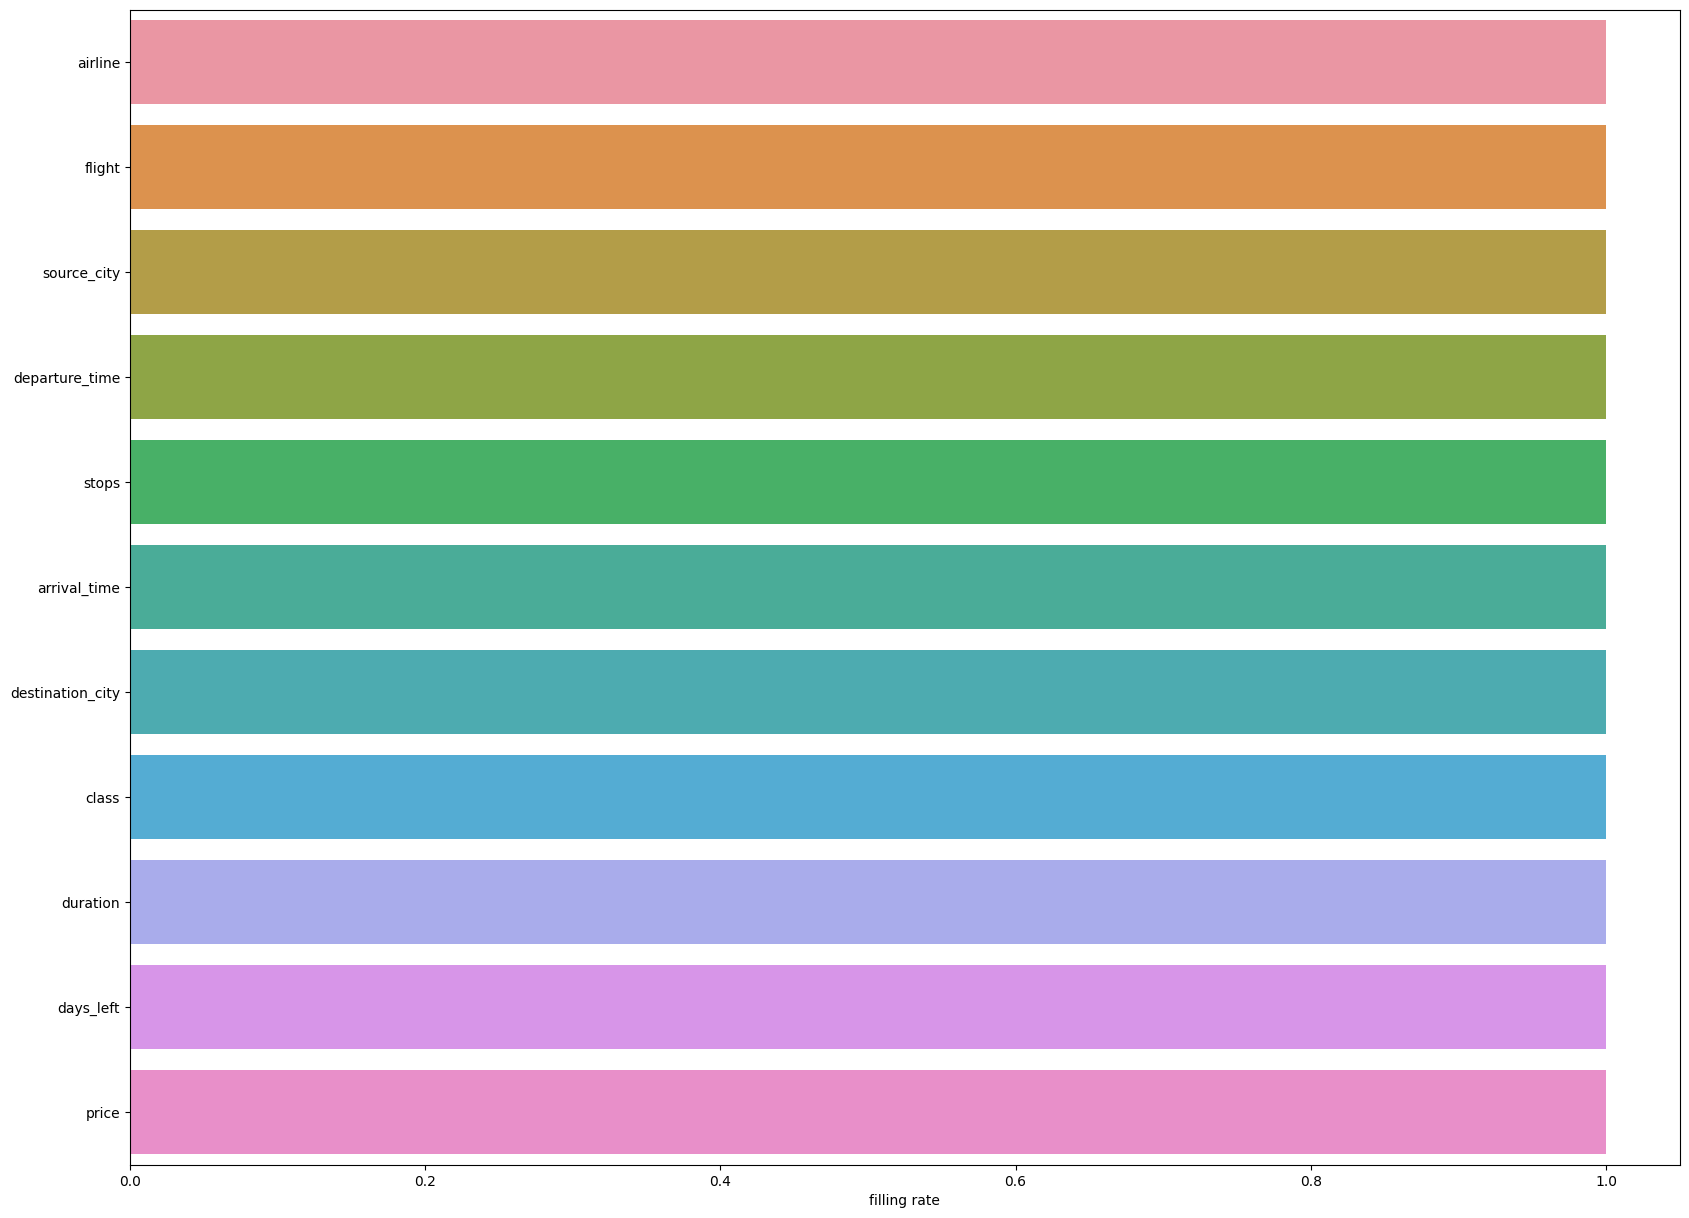

In [13]:
miss_data = data
data_stat=pd.DataFrame(index=['filling rate', 'missing rate'], columns=miss_data.columns )

for col in miss_data.columns:
    nb_nan=miss_data[col].isnull().sum()
    data_stat.loc['filling rate', col]= (miss_data.shape[0]-nb_nan)/(miss_data.shape[0]*1.0)
    data_stat.loc['missing rate', col]= nb_nan/(miss_data.shape[0]*1.0)
from IPython.core.pylabtools import figsize
fig, axe = plt.subplots(figsize=(20, 15))
sns.barplot(y= miss_data.columns, x= data_stat.loc['filling rate'])
plt.show()

It appears that our dataset does not contain any missing values.

## **Detect Outliers**


The outliers are the values that fall below Q1-1.5IQR or above Q3+1.5IQR.


In [14]:
# IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

# Values below Q1-1.5*IQR or above Q3+1.5*IQR are outliers
outliers = data[((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
print(outliers)


<ipython-input-14-8fc1efdb2155>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = data.quantile(0.25)
<ipython-input-14-8fc1efdb2155>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = data.quantile(0.75)
<ipython-input-14-8fc1efdb2155>:8: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = data[((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]


duration         9.34
days_left       23.00
price        37738.00
dtype: float64
          airline   flight source_city departure_time        stops  \
10534     Vistara   UK-706       Delhi      Afternoon  two_or_more   
10535     Vistara   UK-706       Delhi      Afternoon  two_or_more   
10540   Air_India  AI-9887       Delhi  Early_Morning  two_or_more   
10891     Vistara   UK-706       Delhi      Afternoon  two_or_more   
10892     Vistara   UK-706       Delhi      Afternoon  two_or_more   
...           ...      ...         ...            ...          ...   
296297  Air_India   AI-440     Chennai  Early_Morning          one   
296391  Air_India   AI-440     Chennai  Early_Morning          one   
296404    Vistara   UK-838     Chennai          Night          one   
296716  Air_India   AI-440     Chennai  Early_Morning          one   
297661  Air_India   AI-440     Chennai  Early_Morning          one   

       arrival_time destination_city     class  duration  days_left   price  


There are 2233 rows in this DataFrame, which means there are 2233 flights with at least one attribute considered to be an outlier.
For instance, consider the first row in the outliers DataFrame:

*   The flight UK-706 by Vistara from Delhi to Bangalore in the Economy class, which departs in the afternoon, arrives at night, and makes two or more stops, has a duration of 31.25 hours, which is considered an outlier when compared to the rest of the data.
*   Similarly, this flight's price of 12222 might be considered an outlier compared to the other flights.

We can see that there are also flights with very high prices (e.g., 102384), which are considered as outliers.

=> These outliers do not necessarily mean that there are errors or mistakes in the data. For instance, a flight's price may be significantly higher due to factors like the class of the flight (Business vs Economy), number of stops, and so on.

In this particular analysis, we've identified several outliers. However, given the nature of flight prices which can vary greatly depending on multiple factors such as class, airline, number of stops, timing, and proximity to the departure date, these outliers are not necessarily erroneous. They could represent valid price points under certain conditions. Therefore, we will retain these outliers in our dataset and treat them as normal values for the purpose of this analysis.

## **Categorical features**

In [15]:
categorical_features = data.select_dtypes(include=['object']).columns
print(categorical_features)


Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class'],
      dtype='object')


**Ordinal Variables** (These variables can be sorted or have a specific order):
* 'class': The flight class can be seen as ordinal because it can be ranked (Economy < Business).
* 'stops': The number of stops is ordinal because it can be ranked (zero < one < two_or_more).
* 'arrival_time' and 'departure_time': These might be treated as ordinal if you consider time as something that can be ordered from 'Early_Morning' to 'Late_Night'.

**Categorical Variables** (These variables are typically descriptive and cannot be sorted):

* 'destination_city', 'source_city': These are locations and can't be logically ordered.
* 'flight': Flight number is usually nominal because they are more like labels and don't have a mathematical meaning.
* 'airline': Different airlines can't be ranked in a meaningful way.

###**Label Encode our Ordianl Variables**


In [16]:
from sklearn.preprocessing import LabelEncoder

# initialize label encoder
label_encoder = LabelEncoder()

# fit and transform ordinal features
data['class'] = label_encoder.fit_transform(data['class'])
data['stops'] = label_encoder.fit_transform(data['stops'])

data['arrival_time'] = label_encoder.fit_transform(data['arrival_time'])
data['departure_time'] = label_encoder.fit_transform(data['departure_time'])

print(data.head())

    airline   flight source_city  departure_time  stops  arrival_time  \
0  SpiceJet  SG-8709       Delhi               2      2             5   
1  SpiceJet  SG-8157       Delhi               1      2             4   
2   AirAsia   I5-764       Delhi               1      2             1   
3   Vistara   UK-995       Delhi               4      2             0   
4   Vistara   UK-963       Delhi               4      2             4   

  destination_city  class  duration  days_left  price  
0           Mumbai      1      2.17          1   5953  
1           Mumbai      1      2.33          1   5953  
2           Mumbai      1      2.17          1   5956  
3           Mumbai      1      2.25          1   5955  
4           Mumbai      1      2.33          1   5955  


### **One-Hot-Encoding for Categorical Variables.**

In [17]:
data.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

In [18]:
df_encoded = pd.get_dummies(data, columns=['airline', 'source_city', 'destination_city'])
df_encoded.columns

Index(['flight', 'departure_time', 'stops', 'arrival_time', 'class',
       'duration', 'days_left', 'price', 'airline_AirAsia',
       'airline_Air_India', 'airline_GO_FIRST', 'airline_Indigo',
       'airline_SpiceJet', 'airline_Vistara', 'source_city_Bangalore',
       'source_city_Chennai', 'source_city_Delhi', 'source_city_Hyderabad',
       'source_city_Kolkata', 'source_city_Mumbai',
       'destination_city_Bangalore', 'destination_city_Chennai',
       'destination_city_Delhi', 'destination_city_Hyderabad',
       'destination_city_Kolkata', 'destination_city_Mumbai'],
      dtype='object')

In [19]:
df_encoded= df_encoded.drop(['flight'], axis=1)

# data spliting

In [20]:
from sklearn.model_selection import train_test_split
X = df_encoded.drop(['price'], axis=1)
y= df_encoded['price']

In [21]:
# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((240122, 24), (240122,), (60031, 24), (60031,))

# Models

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [23]:
def evaluate_model(y_test, predictions, model_name):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"{model_name}:\nMAE: {mae}\nMSE: {mse}\nR2 Score: {r2}\n")

def plot_predictions(y_test, predictions, model_name):
    plt.figure(figsize=(8,8))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.title(f"True vs Predicted Values ({model_name})")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()


## Linear Regression

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# To predict
lr_predictions = lr.predict(X_test)


## Random Forest

In [25]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# To predict
rf_predictions = rf.predict(X_test)


## Linear SVM

In [26]:
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)

# To predict
svm_predictions = svm.predict(X_test)


## Gradient Boosting

In [27]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

# To predict
gb_predictions = gb.predict(X_test)


## XGBoost

In [28]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# To predict
xgb_predictions = xgb.predict(X_test)


In [29]:
evaluate_model(y_test, lr_predictions, "Linear Regression")
evaluate_model(y_test, rf_predictions, "Random Forest")
evaluate_model(y_test, svm_predictions, "Linear SVM")
evaluate_model(y_test, gb_predictions, "Gradient Boosting")
evaluate_model(y_test, xgb_predictions, "XGBoost")

Linear Regression:
MAE: 4580.820537635067
MSE: 46480151.125554994
R2 Score: 0.9090974507604853

Random Forest:
MAE: 1069.5533495138623
MSE: 7433253.568746717
R2 Score: 0.9854625752675039

Linear SVM:
MAE: 4951.540023341935
MSE: 65052444.77616487
R2 Score: 0.8727750895550572

Gradient Boosting:
MAE: 2910.7397877368703
MSE: 24000176.97532709
R2 Score: 0.9530621734993189

XGBoost:
MAE: 2291.3459281267506
MSE: 16060929.543248858
R2 Score: 0.9685891847749425



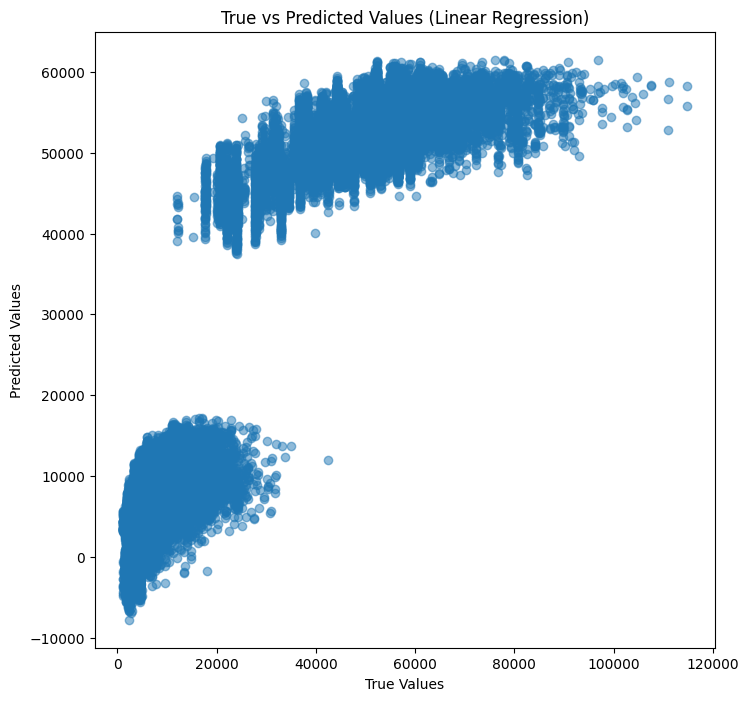

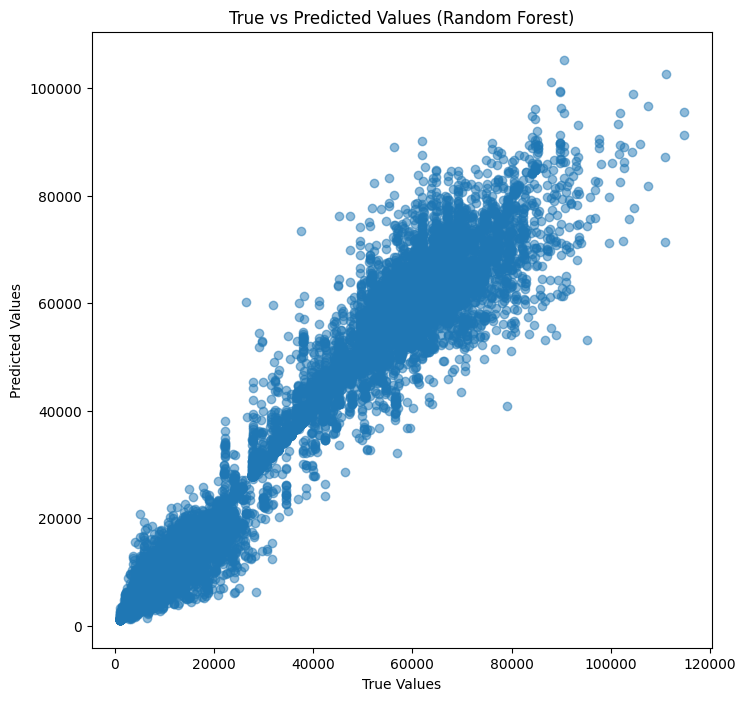

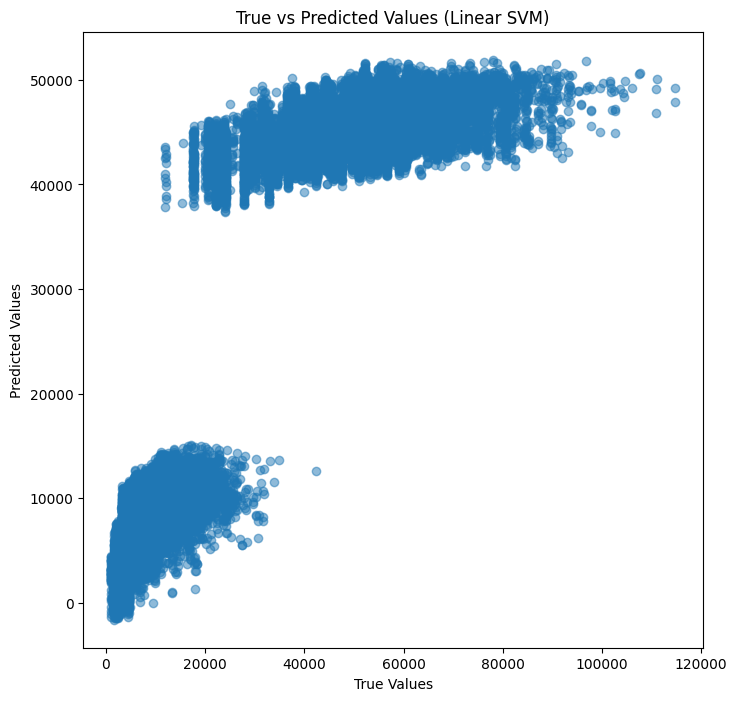

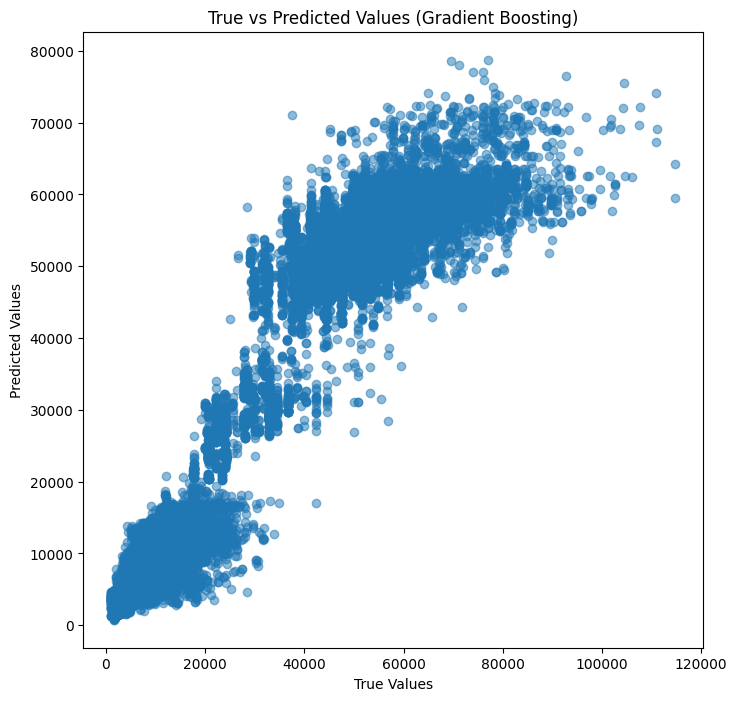

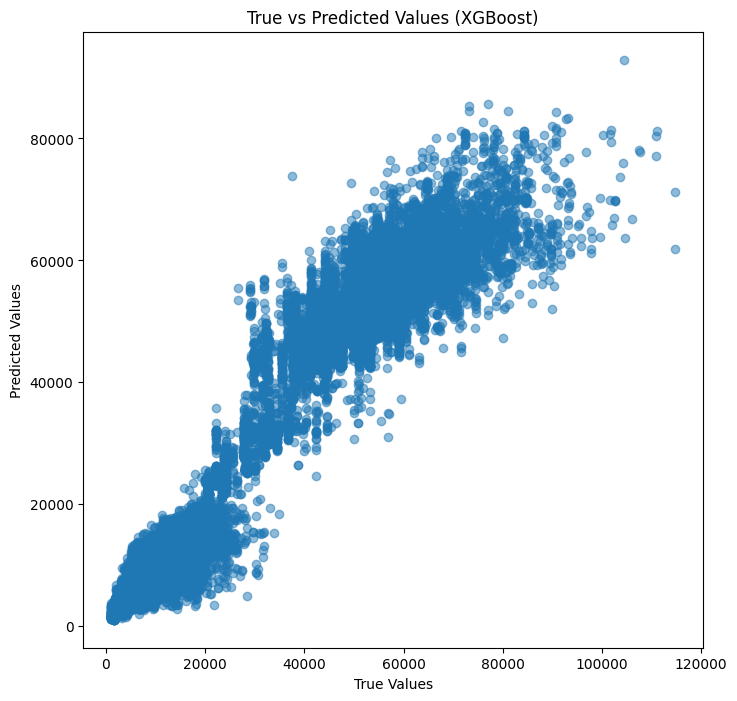

In [30]:
plot_predictions(y_test, lr_predictions, "Linear Regression")
plot_predictions(y_test, rf_predictions, "Random Forest")
plot_predictions(y_test, svm_predictions, "Linear SVM")
plot_predictions(y_test, gb_predictions, "Gradient Boosting")
plot_predictions(y_test, xgb_predictions, "XGBoost")


In [35]:
import pandas as pd

# Create a dictionary with your results
results = {
    'Model': ['Linear Regression', 'Random Forest', 'Linear SVM', 'Gradient Boosting', 'XGBoost'],
    'MAE': [4580.820537635067, 1069.5533495138623, 4951.540023341935, 2910.7397877368703, 2291.3459281267506],
    'MSE': [46480151.125554994, 7433253.568746717, 65052444.77616487, 24000176.97532709, 16060929.543248858],
    'R2 Score': [0.9090974507604853, 0.9854625752675039, 0.8727750895550572, 0.9530621734993189, 0.9685891847749425]
}

# Convert the dictionary to a DataFrame
df_results = pd.DataFrame(results)

# Print the DataFrame
print(df_results)


               Model          MAE           MSE  R2 Score
0  Linear Regression  4580.820538  4.648015e+07  0.909097
1      Random Forest  1069.553350  7.433254e+06  0.985463
2         Linear SVM  4951.540023  6.505244e+07  0.872775
3  Gradient Boosting  2910.739788  2.400018e+07  0.953062
4            XGBoost  2291.345928  1.606093e+07  0.968589
